In [122]:
import json
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn import metrics

In [123]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [124]:
file = '../data_resources/topics/vng_training_cleaned_no_news.json'
data_a = json.load(open(file))

topics_file = '../data_resources/topics/vng_topics_slug.json'
topic_data = json.load(open(topics_file))

additional = '../data_resources/topics/vng_additional_data.json'
data_b = json.load(open(additional))

data = []
sub_topics = []

topics = topic_data['topics']
for main in topics:
    for sub in main['sub']:
        sub_topics.append(sub['slug'])

for obj in data_a:
    data.append(obj)
    if obj['sub_topic'] not in sub_topics:
        print(obj['sub_topic'])
        
for obj in data_b:
    
    if obj['sub_topic'] not in sub_topics:
        print(obj['sub_topic'])
    
    if len(obj['content']) > 1:    
        data.append(obj)

In [125]:
transformer = TfidfVectorizer(smooth_idf=True, max_df=0.3)
# transformer = CountVectorizer() # - descreases performance

corpus = []
y = []

for obj in data:
    content = obj['content']
    corpus.append(content)
    
    y.append(obj['sub_topic'])

<module 'matplotlib.pyplot' from '/home/rothweiler/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

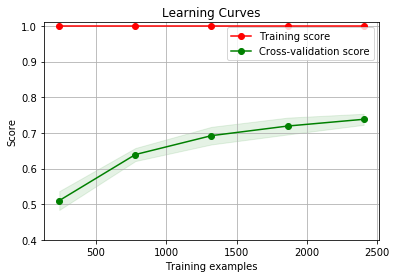

In [128]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

X = transformer.fit_transform(corpus)

estimator = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=50, tol=None)
plot_learning_curve(estimator, title, X, y, ylim=(0.4, 1.01), cv=cv, n_jobs=5)

In [117]:
X_train_corpus, X_test_corpus, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

X_train = transformer.fit_transform(X_train_corpus)
X_test = transformer.transform(X_test_corpus)

print(np.shape(X_train))
print(np.shape(y_test))

(2404, 25557)
(602,)


In [118]:

# clf = SVC(kernel="linear", C=3.75, probability=True) # 0.703

clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=50, tol=None)
%time clf = OneVsRestClassifier(clf).fit(X_train, y_train)

%time y_pred = clf.predict(X_test)

proba = clf.predict_proba(X_test[0])
print(len(proba[0]))

score = accuracy_score(y_test, y_pred)

print(score)

CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s
CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 21.7 ms
142
0.7259136212624585


In [119]:
import pickle

pickle.dump( clf, open("../app/modules/topics/models/classifier.sav", 'wb') )
pickle.dump( transformer, open("../app/modules/topics/models/transformer.sav", 'wb') )

In [120]:
print(metrics.classification_report(y_test, y_pred))

                                                     precision    recall  f1-score   support

                                        aanbesteden       1.00      0.25      0.40         4
                              aanpak-radicalisering       1.00      1.00      1.00         2
                 aansluiting-onderwijs-arbeidsmarkt       0.67      0.67      0.67         3
                                              afval       0.50      0.50      0.50         2
                                                apv       0.50      0.50      0.50         2
                                 arbeidsmarktbeleid       0.00      0.00      0.00         3
                              arbeidsomstandigheden       0.50      1.00      0.67         1
                                 arbeidsvoorwaarden       0.67      0.44      0.53         9
                                          archieven       0.75      0.60      0.67         5
                            architectuur-en-erfgoed       0.00      0

/home/rothweiler/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rothweiler/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [62]:
"""
Parameters for tuning:
- tansformer max_df/min_df
- svm C value
- svm kernel
"""

clf1 = SVC(kernel="linear", C=3.75, probability=True) # 0.682
%time clf1 = OneVsRestClassifier(clf1).fit(X_train, y_train)

clf2 = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=100, tol=None)

# clf2 = RandomForestClassifier(max_depth=20,n_estimators=30,max_features=5000,n_jobs=-1) # 0.61
%time clf2 = OneVsRestClassifier(clf2).fit(X_train, y_train)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [63]:
clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='soft')
%time clf.fit(X_train, y_train)
%time y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)

print(score)

KeyboardInterrupt: 

/home/rothweiler/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rothweiler/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AxisError: axis 1 is out of bounds for array of dimension 1

0.7171270718232045


In [64]:
clf2.predict(X_test)
score = accuracy_score(y_test, y_pred)

print(score)

NotFittedError: This SGDClassifier instance is not fitted yet

In [ ]:

# Classifiers experimented with and score achieved:
classifiers = {
    'svm1': SVC(kernel="linear", C=3.75), # 0.682
    'randomf': RandomForestClassifier(max_depth=20,n_estimators=30,max_features='auto',n_jobs=-1), # 0.61
}

In [ ]:
for clf in classifiers:
    print(clf)
    classifier = classifiers[clf]

    %time clf = OneVsRestClassifier(classifier).fit(X_train, y_train)
    %time y_pred = clf.predict(X_test)

    score = accuracy_score(y_test, y_pred)
   
    print(score)

In [ ]:
%time clf = OneVsRestClassifier(classifiers['randomf']).fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)